In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statistics import mean

In [2]:
plt.style.use("seaborn-deep")

## Basis-statistik fra ECDC

In [3]:
from onlineGetter import get_ecdc_data
ecdc = get_ecdc_data()

In [4]:
ecdc[ecdc.countriesAndTerritories == "Estonia"]

dateRep  day  month  year  cases  deaths countriesAndTerritories  \
2772 2020-04-07    7      4  2020     11       4                 Estonia   
2773 2020-04-06    6      4  2020     79       2                 Estonia   
2774 2020-04-05    5      4  2020     57       1                 Estonia   
2775 2020-04-04    4      4  2020    103       1                 Estonia   
2776 2020-04-03    3      4  2020     79       6                 Estonia   
...         ...  ...    ...   ...    ...     ...                     ...   
2861 2020-01-04    4      1  2020      0       0                 Estonia   
2862 2020-01-03    3      1  2020      0       0                 Estonia   
2863 2020-01-02    2      1  2020      0       0                 Estonia   
2864 2020-01-01    1      1  2020      0       0                 Estonia   
2865 2019-12-31   31     12  2019      0       0                 Estonia   

     geoId countryterritoryCode  popData2018  
2772    EE                  EST    1320884.0  
2773    EE                  EST    1320884.0  
2774    EE                  EST    1320884.0  
2775    EE                  EST    1320884.0  
2776    EE                  EST    1320884.0  
...    ...                  ...          ...  
2861    EE                  EST    1320884.0  
2862    EE                  EST    1320884.0  
2863    EE                  EST    1320884.0  
2864    EE                  EST    1320884.0  
2865    EE                  EST    1320884.0  

[94 rows x 10 columns]

In [5]:
base_date = np.datetime64('2020-02-01')
print(base_date)

2020-02-01


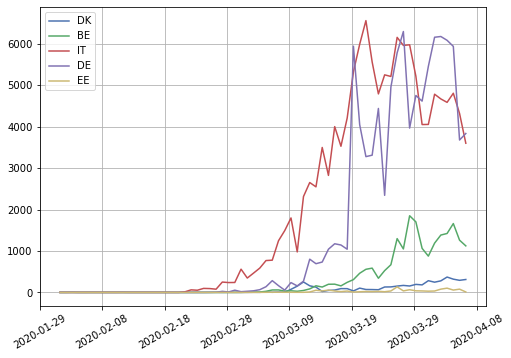

In [6]:
countries = [
    "DK",
    "BE",
    "IT",
    "DE",
    "EE"
]

def create_std_ecdc_plot(countries, parameterx, parametery):
    fig, ax = plt.subplots()

    for country in countries:
        land = ecdc[(ecdc.geoId == country) & (ecdc.dateRep > base_date)]
        ax.plot(land[[parameterx]], land[[parametery]], label=country)
    
    plt.xticks(rotation=30)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 10))
    ax.legend()
    plt.grid()
    plt.show()

plt.rcParams["figure.figsize"] = (8,5.5)
create_std_ecdc_plot(countries, "dateRep", "cases")

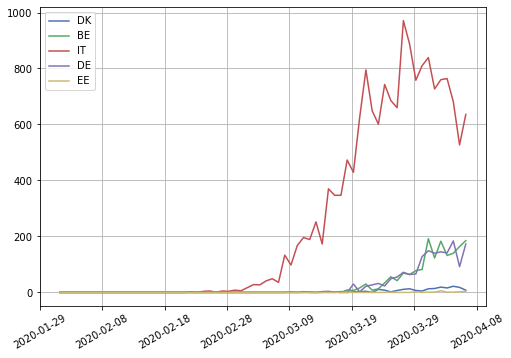

In [7]:
create_std_ecdc_plot(countries, "dateRep", "deaths")

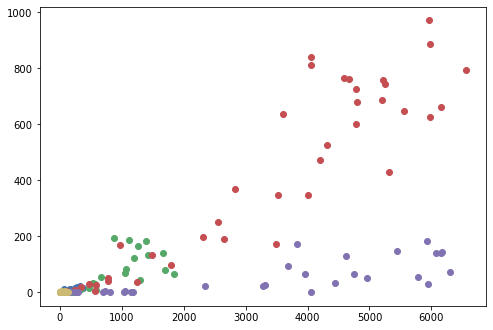

In [8]:
for country in countries:
    land = ecdc[(ecdc.geoId == country) & (ecdc.dateRep > base_date)]
    plt.scatter(land.cases, land.deaths)

In [9]:
ecdc = ecdc.sort_values(by=["dateRep"])
running_total = ecdc.groupby("geoId")[["dateRep","geoId", "cases", "deaths"]].cumsum()
running_total.columns = ["cases_cumsum", "deaths_cumsum"]

In [10]:
ecdc = ecdc.merge(running_total, right_index=True, left_index=True)

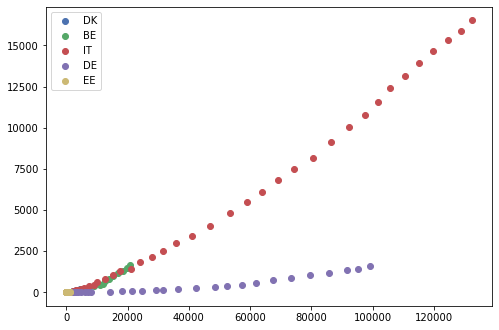

In [11]:
for country in countries:
    land = ecdc[(ecdc.geoId == country) & (ecdc.dateRep > base_date)]
    plt.scatter(land.cases_cumsum, land.deaths_cumsum, label=country)
plt.legend()

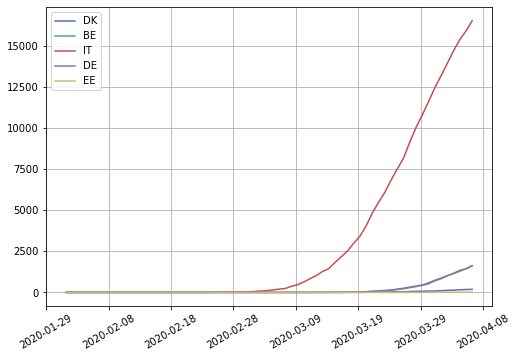

In [12]:
create_std_ecdc_plot(countries, "dateRep", "deaths_cumsum")

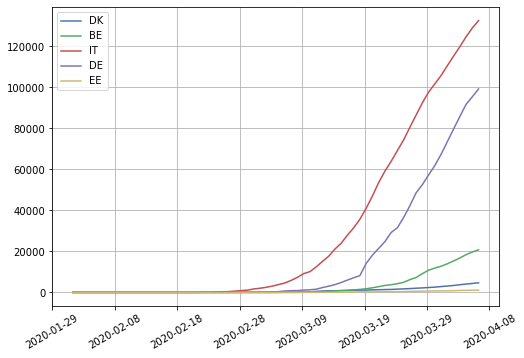

In [13]:
create_std_ecdc_plot(countries, "dateRep", "cases_cumsum")

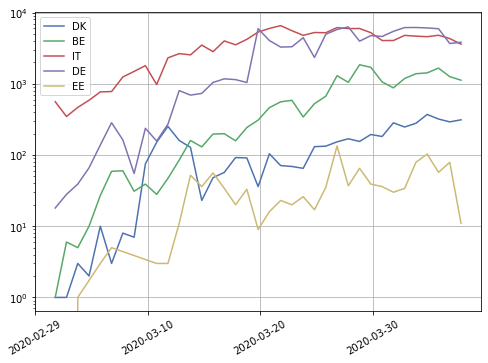

In [14]:
fig, ax = plt.subplots()

for country in countries:
    land = ecdc[(ecdc.geoId == country) & (ecdc.dateRep > np.datetime64('2020-03-01'))]
    ax.plot(land[["dateRep"]], land[["cases"]], label=country)

plt.xticks(rotation=30)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))
plt.yscale("log")
ax.legend()
plt.grid()
plt.show()

## Estimering af dødelighed over alder

Vi anvender følgende model i estimeringen: 

In [15]:
def logistic_mod(x, x_0, max_val, growth_rate):
    L = max_val
    k = growth_rate
    
    return L/(1+np.e**(-k*(x-x_0)))

Vi forudsætter en model, der ser nogenlunde sådan ud: 

$\large{\theta(x) =} \Large{
    \frac{L\ I_a(x)}
    {1+\text{e}^{-k(x-x_0)}}}$

$
\large{\phi(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}}
$

$ \Large{I_a(x)=\frac{
    \phi(x)\:\Phi(ax)}
    {\Phi(0)}}
    $

Oversat til menneskesprog: 
dødeligheden for et givent alderstrin, $\theta$, er beskrevet ved en logistisk funktion, der kobler alder, $x$, til IFR. 
Samtidig er antallet af smittede, $I$, ikke en fast procentdel for alle alderstrin, da det samlet vurderes, at yngre grupper vil have større chance for at komme i kontakt med smittede pga. deres kontaktmønstre. $I$ kan korrigeres for lavere chancer for smitte for yngre populationer samt kontaktmønstre o.l., men vi vil her blot henholde os til at lave en simpel estimering af tallet. 

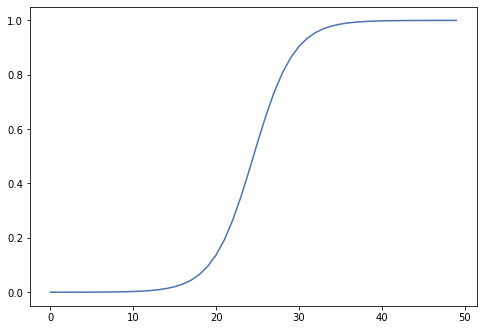

In [16]:
plt.plot(logistic_mod(np.linspace(-10,10), 0, 1, 1))

Dernæst henter vi en række datapunkter, som vi vil anvende til at estimere vores logistiske model. 

In [17]:
age_death = [
    0.000626537, 0.0003,        0.000311741,
    0.00347113,  0.006737667,   0.019181854,
    0.072922914, 0.2,           0.230151607,
    #0.24
]

age = [
    "0-9 år",    "10-19 år",    "20-29 år",
    "30-39 år",  "40-49 år",    "50-59 år",
    "60-69 år",  "70-79 år",    "80-89 år",
    #"90-99 år"
]


nw = [x.replace(' år', '').split('-') for x in age]
nw = [(int(x[0]), int(x[1])) for x in nw]
nw = [mean(x) for x in nw]
nw.sort()
age_dict = dict(zip(nw, age_death))

Da vi kender max-værdien på den data, som vi prøver at estimere, så kan vi f

In [18]:
def logistic_mod_fit(x, L, x_0, growth_rate):
    # L = 0.24
    return logistic_mod(x, x_0, L, growth_rate)

In [19]:
from scipy.optimize import curve_fit

In [20]:
ydata = np.array(list(age_dict.values()))
xdata = np.array(list(age_dict.keys()))

In [21]:
popt, pcov = curve_fit(logistic_mod_fit, xdata, ydata, bounds=((0, 0, 0), (2, 100, 2)))
popt

array([ 0.23705718, 67.6801843 ,  0.23108405])

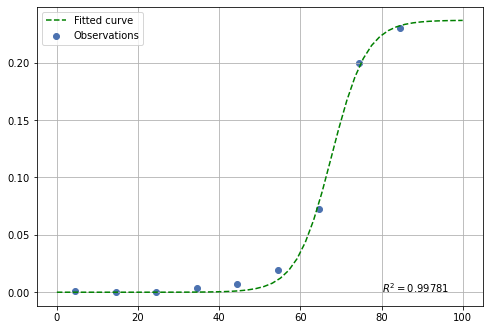

In [22]:
from sklearn.metrics import r2_score

test_xdata = np.linspace(0,100)
test = logistic_mod_fit(test_xdata, *popt)
plt.scatter(xdata, ydata, label="Observations")
plt.plot(test_xdata, test, "g--", label="Fitted curve")
text_str = "$R^2= $"+str(round(r2_score(ydata, logistic_mod_fit(xdata, *popt)),5))
plt.text(80, 0.0, text_str)
plt.grid()
plt.legend()

In [23]:
logistic_mod_fit(xdata, *popt)

array([1.08188896e-07, 1.09085282e-06, 1.09984954e-05, 1.10849967e-04,
       1.11296163e-03, 1.07629093e-02, 7.68355896e-02, 1.96432754e-01,
       2.32292613e-01])

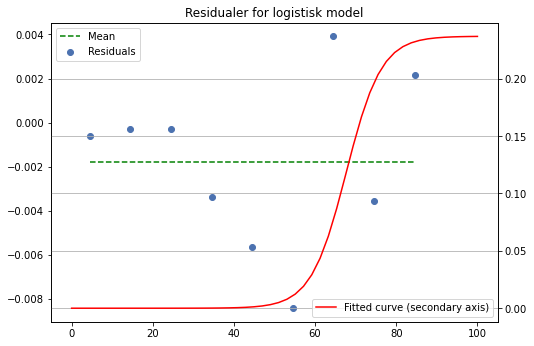

In [24]:
resid = logistic_mod_fit(xdata, *popt)-ydata
plt.scatter(xdata, resid, label="Residuals")
plt.plot(xdata, [mean(resid) for x in range(len(xdata))], '--g', label="Mean")
plt.legend(loc=2)
ax2 = plt.twinx()
ax2.plot(test_xdata, test, "r-", label="Fitted curve (secondary axis)")
plt.title("Residualer for logistisk model")
plt.legend(loc=4)
plt.grid()

In [25]:
popt

array([ 0.23705718, 67.6801843 ,  0.23108405])

In [26]:
folk = pd.read_csv('folk2.csv', delimiter="\t", encoding="utf-8")
folk = folk[["alder", "2020"]]
folk.columns = ["alder", "antal"]
folk.alder = folk.alder.apply(lambda x: int(x.replace(" år", "")))
folk["dødelighed"] = folk.alder.apply(lambda x: logistic_mod_fit(x, *popt))

In [27]:
folk["alle_smittet_gr"] = folk.antal * folk.dødelighed
folk["pct80_smittet_gr"] = folk.antal*0.8*folk.dødelighed
print("Alle smittet:", int(folk.alle_smittet_gr.sum()))
print("80% smittet:", int(folk.pct80_smittet_gr.sum()))
print("IFR for grundforløb:", round(folk.alle_smittet_gr.sum()/folk.antal.sum()*100,2))

Alle smittet: 233076
80% smittet: 186461
IFR for grundforløb: 4.0


In [28]:
procent_døde_gr_forløb = folk.alle_smittet_gr.sum()/folk.antal.sum()*100

In [29]:
folk["dødelighed_1pct"] = folk.dødelighed/procent_døde_gr_forløb
folk['alle_smittet_1pct'] = folk.antal * folk.dødelighed_1pct
print("Ved samlet IFR på 1% og ved 80% smittede (alle aldersgrupper smittes lige meget):",
      int((folk.alle_smittet_1pct*0.8).sum()))

Ved samlet IFR på 1% og ved 80% smittede (alle aldersgrupper smittes lige meget): 46582


In [30]:
folk.alle_smittet_1pct.sum()/folk.antal.sum()*100

1.0

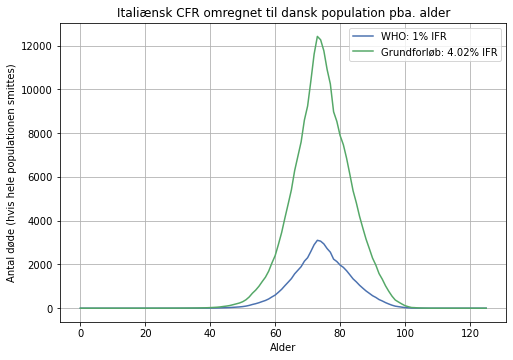

In [31]:
plt.plot(folk.alder, folk.alle_smittet_1pct, label="WHO: 1% IFR")
plt.plot(folk.alder, folk.alle_smittet_gr, label="Grundforløb: 4.02% IFR")
plt.title("Italiænsk CFR omregnet til dansk population pba. alder")
plt.grid()
plt.xlabel("Alder")
plt.ylabel("Antal døde (hvis hele populationen smittes)")

plt.legend()

## Test af mere aldersdata

In [32]:
import os
os.listdir("age_data")

['island.csv',
 'italien.csv',
 'kina.csv',
 'opendata_covid19_test_results.csv',
 'WA.csv',
 'worldometer.csv']

In [33]:
### Island
isl = pd.read_csv("age_data/island.csv")
isl.Age = isl.Age.apply(lambda x: mean([int(x) for x in x.split('-')]))
isl.columns = ["age", "act_inf", "recov", "deaths"]
isl["cfr"] = isl.deaths/(isl.act_inf +isl.recov)


### Italien 
it = pd.read_csv("age_data/italien.csv")
it_age = pd.Series([[x*10,x*10-1+10] for x in range(10)])
it_age.name = "age"
it = it.merge(it_age, right_index=True, left_index=True)
it["min_age"] = it.age.apply(lambda x: x[0])
it["max_age"] = it.age.apply(lambda x: x[1])
it['mean_age'] = it.age.apply(lambda x: mean(x))
it = it.drop(columns=["age"])
it.columns = ['deadliness', 'min_age', 'max_age', 'mean_age']

### China
ch = pd.read_csv("age_data/kina.csv", delimiter="\t").reset_index()
ch.columns = ["min_age", "max_age", "crude", "adj_censoring", "add_adj_demo_under_ascertainment"]
ch['mean_age'] = (ch.min_age+ch.max_age)/2

### Washington
wa = pd.read_csv("age_data/WA.csv", delimiter="\t")

### World'o'meter
wom = pd.read_csv("age_data/worldometer.csv", delimiter="\t")

## Italien

Text(0.5, 1.0, 'Italien: CFR over alder')

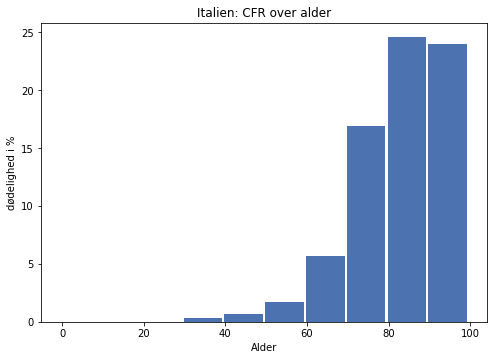

In [34]:
plt.bar(it.mean_age, it.deadliness, width=9.5)
plt.xlabel("Alder")
plt.ylabel("dødelighed i %")
plt.title("Italien: CFR over alder")

Passer godt med det andet datasæt fra Italien: [ 0.25019795 70.53264838  0.19831812]


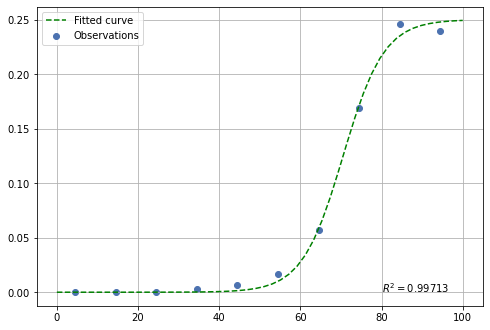

In [35]:
xdata = it.mean_age
ydata = it.deadliness/100

popt2, pcov = curve_fit(logistic_mod_fit, xdata, ydata, bounds=((0, 40, 0), (5, 120, 5)))

test_xdata = np.linspace(0,100)
test = logistic_mod_fit(test_xdata, *popt2)
plt.scatter(xdata, ydata, label="Observations")
plt.plot(test_xdata, test, "g--", label="Fitted curve")
text_str = "$R^2= $"+str(round(r2_score(ydata, logistic_mod_fit(xdata, *popt2)),5))
plt.text(80, 0.0, text_str)
plt.grid()
plt.legend()
print("Passer godt med det andet datasæt fra Italien:", popt2)

## Kina 

Text(0.5, 1.0, 'Kina: CFR over alder')

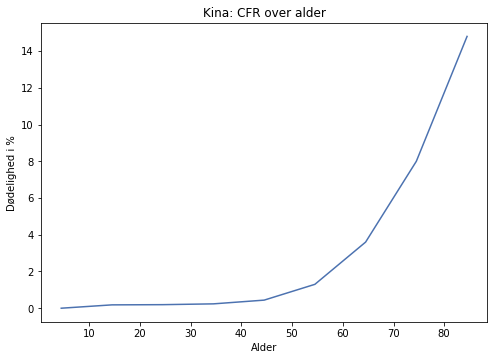

In [36]:
plt.plot(ch.mean_age, ch.crude, label="Crude")
#plt.plot(ch.mean_age, ch.adj_censoring, label="adj_censor")
#plt.plot(ch.mean_age, ch.add_adj_demo_under_ascertainment, label="add_adj")
plt.xlabel("Alder")
plt.ylabel("Dødelighed i %")
plt.title("Kina: CFR over alder")
#plt.legend()

In [37]:
print("Islands CFR:", round(isl.deaths.sum()/(isl.act_inf.sum()+isl.recov.sum())*100,4), "%")

Islands CFR: 0.3654 %


## Estland

In [38]:
es = pd.read_csv("age_data\opendata_covid19_test_results.csv")
es.columns = ['id', 'gender', 'age', 'country', 'county', 'test_result',
       'test_date', 'result_time', 'analysis_time']
es.test_result = es.test_result.apply(
    lambda x: 1 if x == "P" else (0 if x == "N" else np.nan)
)
date_transform = lambda x: np.datetime64(x)
es.test_date = es.test_date.apply(date_transform)
es.result_time = es.result_time.apply(date_transform)
es.analysis_time = es.analysis_time.apply(date_transform)

print("Positive test i %:", round(es.test_result.sum()/es.test_result.count()*100,2),"%")
print("Samlet antal test:", len(es))

Positive test i %: 4.57 %
Samlet antal test: 26416


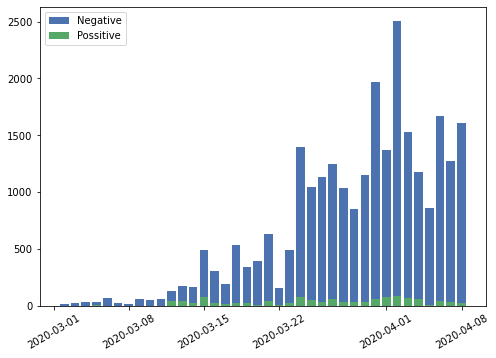

In [127]:
es_date = es[es.test_date > np.datetime64("2020-03-01")]

counted_test = es_date.groupby("test_date").count().id
plt.bar(counted_test.index, counted_test, label="Negative")
plt.xticks(rotation=30)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))

counted_test = es_date.groupby("test_date").test_result.sum()
plt.bar(counted_test.index, counted_test, label="Possitive")
plt.xticks(rotation=30)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))

plt.legend()

In [40]:
def age_splitter(x):
    if type(x) is float: 
        return ["Unknown", "Unknown"]
    if len(x.split('-')) > 1:
         return [float(x) for x in x.split("-")]
    elif x=="üle 85":
        return [85, 89]

es = pd.read_csv("age_data\opendata_covid19_test_results.csv")
es.columns = ['id', 'gender', 'age', 'country', 'county', 'test_result',
       'test_date', 'result_time', 'analysis_time']
es.test_result = es.test_result.apply(
    lambda x: 1 if x == "P" else (0 if x == "N" else np.nan)
)   
date_transform = lambda x: np.datetime64(x)
es.test_date = es.test_date.apply(date_transform)
es.result_time = es.result_time.apply(date_transform)
es.analysis_time = es.analysis_time.apply(date_transform)

es["max_age"] = es.age.apply(lambda x: age_splitter(x)[1])
es["min_age"] = es.age.apply(lambda x: age_splitter(x)[0])
es = es[es.max_age != "Unknown"]
es.max_age = es.max_age.astype('int64')
es.min_age = es.min_age.astype('int64')
es["avg_age"] = (es.max_age+es.min_age)/2
es = es.sort_values("min_age")

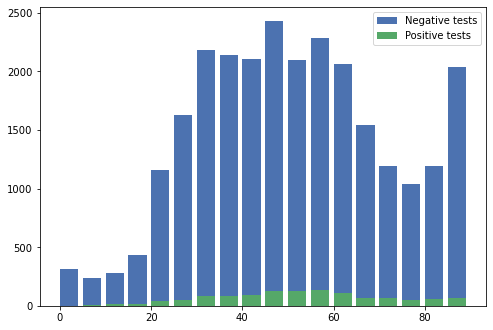

In [41]:
es_group_age = es.groupby("avg_age").test_result
plt.bar(es_group_age.count().index, es_group_age.count(), 4, label="Negative tests")
plt.bar(es_group_age.count().index, es_group_age.sum(), 4, label="Positive tests")
plt.legend()

Text(0, 0.5, 'Procent af test udført i perioden')

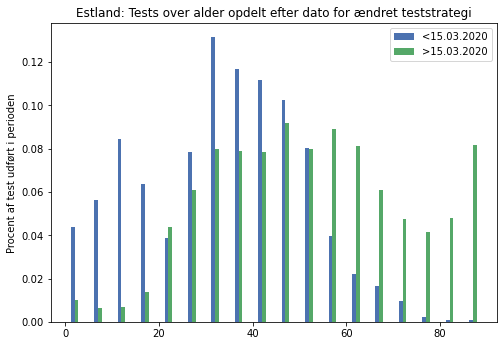

In [42]:
es_før = es[es.test_date < np.datetime64("2020-03-15")]
es_efter = es[es.test_date > np.datetime64("2020-03-15")]
es_før_group = es_før.groupby("avg_age").avg_age
plt.bar(es_før_group.count().index-0.4, 
        es_før_group.count()/es_før.avg_age.count(), 
        label="<15.03.2020")
es_efter_group = es_efter.groupby("avg_age").avg_age
plt.bar(es_efter_group.count().index+0.4, 
        es_efter_group.count()/es_efter.avg_age.count(), 
        label=">15.03.2020")
plt.legend()
plt.title("Estland: Tests over alder opdelt efter dato for ændret teststrategi")
plt.ylabel("Procent af test udført i perioden")
# plt.bar(es_efter)

In [43]:
print("Tests før den 15.03.2020:\t", len(es_før))
print("Tests efter den 15.03.2020:\t", len(es_efter))

Tests før den 15.03.2020:	 958
Tests efter den 15.03.2020:	 24880


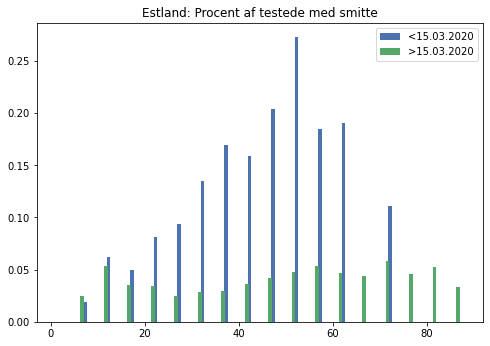

In [44]:
es_før_smit_pct = es_før.groupby("avg_age").test_result.sum()/es_før.groupby("avg_age").test_result.count()
es_efter_smit_pct = es_efter.groupby("avg_age").test_result.sum()/es_efter.groupby("avg_age").test_result.count()
plt.bar(es_før_smit_pct.index+0.3, 
        es_før_smit_pct, 
        label="<15.03.2020")
plt.bar(es_efter_smit_pct.index-0.3, 
        es_efter_smit_pct, 
        label=">15.03.2020")
plt.title("Estland: Procent af testede med smitte")
plt.legend()

$
\large{\phi(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}}
$

$ \large{I_a(x)=\frac{
    \phi(x)\:\Phi(ax)}
    {\Phi(0)}}
    $

In [67]:
def norm_dist(x, c, a, b):
    d1 = 1/(c*np.sqrt(2*np.pi))
    d20 = (-1/2)*(((x-a)/c)**2)
    d2 = np.e**d20
    return d1*d2*b

[15.69697495 47.20814081  8.61786218]


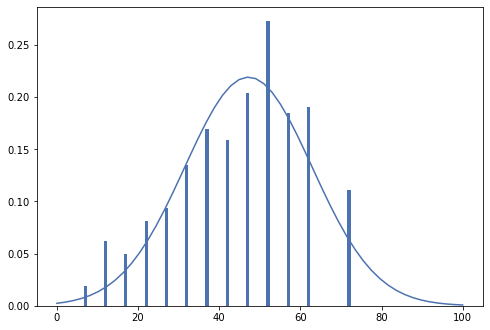

In [66]:
xdata = es_før_smit_pct.index
ydata = es_før_smit_pct
popt_dist, pcov = curve_fit(norm_dist, xdata, ydata, bounds=((0, 0, 0), (100, 120, 10)))
print(popt_dist)
plt.bar(xdata, ydata)
plt.plot(np.linspace(0,100), norm_dist(np.linspace(0,100), *popt_dist))

In [68]:
folk["basis_dist"] = folk.alder.apply(lambda x: norm_dist(x, *popt_dist))**0.15
folk["mod1Forløb"] = folk.antal*folk.basis_dist
folk["mod1Forløb80pct"] = folk.mod1Forløb/(folk.mod1Forløb.sum()/folk.antal.sum()*100)*80

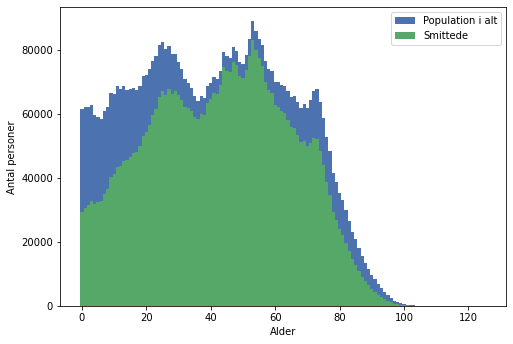

In [69]:
plt.bar(folk.alder, folk.antal, 1, label="Population i alt")
plt.bar(folk.alder, folk.mod1Forløb80pct, 1, label="Smittede")
plt.xlabel("Alder")
plt.ylabel("Antal personer")
plt.legend()

In [70]:
folk.mod1Forløb80pct.sum()/folk.antal.sum()

0.8

Text(0, 2200, 'Antal døde: 43309')

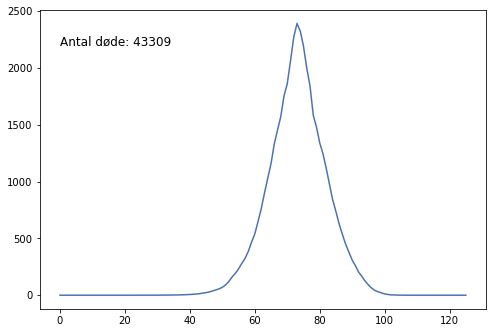

In [71]:
folk["mod1Dødelighed"] = folk.mod1Forløb80pct*folk.dødelighed_1pct
plt.plot(folk.mod1Dødelighed)
plt.text(0, 2200, "Antal døde: " + str(int(folk.mod1Dødelighed.sum())), fontsize=12)